In [6]:
import pandas as pd
import numpy as np
import gensim
from nltk import RegexpTokenizer
from nltk.corpus import stopwords

In [7]:
data = pd.read_pickle('data_clean_4cols.pickle')
candidate_data = pd.DataFrame()
candidate_data = (data
                  .drop(['id', 'message'], axis=1)
                  .drop_duplicates('from_name')
                  .set_index('from_name'))
G = data.groupby('from_name',as_index=False)['message'].apply(' '.join)
candidate_data['Partei_ABK']=G.values
candidate_data.columns = ['text']
candidate_data['tags']=candidate_data.index
candidate_data.shape

(1001, 2)

In [8]:
tokenizer = RegexpTokenizer(r'\w+')
#This function does all cleaning of data using two objects above
def nlp_clean(data):
    new_data = []
    for d in data:
        new_str = d.lower()
        dlist = tokenizer.tokenize(new_str)
        new_data.append(dlist)
    return new_data
candidate_data['text'] = candidate_data['text'].str.replace('\d+', '')#deleting nums
candidate_data['text']= nlp_clean(candidate_data['text'])


In [9]:
from gensim.models import Doc2Vec
import gensim.models.doc2vec
from collections import OrderedDict
import multiprocessing

In [10]:
class LabeledLineSentence(object):
    def __init__(self, doc_list, labels_list):
        self.labels_list = labels_list
        self.doc_list = doc_list
    def __iter__(self):
        for idx, doc in enumerate(self.doc_list):
              yield gensim.models.doc2vec.LabeledSentence(doc,    
[self.labels_list[idx]])

In [11]:
#iterator returned over all documents
corpus = LabeledLineSentence(candidate_data['text'], candidate_data['tags'])


In [12]:
cores = multiprocessing.cpu_count()
assert gensim.models.doc2vec.FAST_VERSION > -1, "This will be painfully slow otherwise"

In [13]:
model = Doc2Vec(alpha=0.025, min_alpha=0.025,workers=cores)  # use fixed learning rate
model.build_vocab(corpus)
for epoch in range(10):
    model.train(corpus, total_examples=model.corpus_count, epochs=model.iter)
    model.alpha -= 0.002  # decrease the learning rate
    model.min_alpha = model.alpha  # fix the learning rate, no decay

In [14]:
model.wv.vocab.keys()

dict_keys(['ich', 'fordere', 'spd', 'und', 'grüne', 'in', 'hessen', 'auf', 'mit', 'der', 'linken', 'gemeinsam', 'dafür', 'zu', 'kämpfen', 'dass', 'ein', 'bekannter', 'hessischer', 'rassist', 'schwulen', 'hasser', 'nicht', 'den', 'bundestag', 'kommt', 'insbesondere', 'die', 'grünen', 'müssen', 'ihrem', 'koalitionspartner', 'cdu', 'klar', 'machen', 'sie', 'afd', 'stärkt', 'wenn', 'im', 'braunen', 'nach', 'stimmen', 'fischt', 'für', 'soziale', 'gerechtigkeit', 'straße', 'meine', 'rede', 'zur', 'kandidatur', 'platz', 'hessischen', 'liste', 'bundestagswahl', 'wir', 'einer', 'abstimmung', 'höhere', 'sichere', 'renten', 'menschen', 'erhalten', 'immer', 'weniger', 'von', 'dem', 'reichtum', 'erarbeiten', 'damit', 'muss', 'endlich', 'schluss', 'sein', 'mindestlohn', 'euro', 'erhöht', 'leiharbeit', 'verboten', 'werden', 'frau', 'nahles', 'kann', 'uns', 'dumm', 'verkaufen', 'wissen', 'fdp', 'verantwortlich', 'sind', 'bericht', 'zeige', 'es', 'eine', 'verfestigte', 'ungleichheit', 'bei', 'vermögen'

In [16]:
docvec = model.docvecs[1]
print (docvec)

[ -9.95156407e-01   1.34477198e+00  -5.77866554e-01   1.67225015e+00
  -1.58075881e+00   1.08575821e+00   1.16041648e+00   1.06622934e+00
  -1.10005426e+00   1.31096339e+00   4.23967302e-01   1.24915406e-01
  -1.33070910e+00  -1.16889811e+00  -4.80238140e-01   9.84041631e-01
   2.32910499e-01   8.42567623e-01  -2.38096118e+00  -1.48388648e+00
  -2.66154170e+00  -1.74556828e+00   1.40272319e+00   3.75463295e+00
   1.26841569e+00  -1.84332097e+00  -2.13958576e-01  -2.50818682e+00
  -1.06248415e+00  -4.93586826e+00  -6.14220917e-01   1.82140529e-01
   9.64719206e-02   5.23034930e-01  -1.85363376e+00  -2.50837374e+00
  -1.34507513e+00   6.45967200e-02   8.50913584e-01  -1.47631252e+00
   1.42539823e+00   2.82095575e+00   2.52875596e-01  -1.13363016e+00
   1.38594627e+00   2.63875693e-01  -4.84201968e-01  -8.83793414e-01
   1.59887940e-01  -1.59999311e+00   2.72108817e+00   7.62756705e-01
   5.55599332e-02   5.33042178e-02  -1.65884554e+00  -1.36538422e+00
  -3.69548857e-01   1.66930401e+00

In [17]:
similar_doc = model.docvecs.most_similar(14) 
print (similar_doc)

[('Hendrik Hoppenstedt', 0.6465499997138977), ('Luise Amtsberg', 0.6307814121246338), ('Michael Stübgen', 0.628629207611084), ('Bärbel Bas', 0.6236838102340698), ('Wolf-Dieter Liese', 0.6168413758277893), ('Michael Kruse', 0.6163330674171448), ('Henning Otte', 0.6108330488204956), ('Bernd Liebhardt', 0.6075664162635803), ('Oswin Veith - Für die Wetterau im Bundestag', 0.6030875444412231), ('Rita Nowak', 0.6025898456573486)]


In [20]:
print (model.docvecs.most_similar('Diyar Agu'))

[('Günter Lach', 0.7083964347839355), ('Karin Strenz, MdB', 0.6600978374481201), ('Rita Schwarzelühr-Sutter', 0.6506839394569397), ('Dennis Wamhoff', 0.6499919295310974), ('Yasmin Fahimi', 0.6403940916061401), ('Britta Haßelmann', 0.6242624521255493), ('Waldemar Westermayer', 0.6213269233703613), ('Kevin Hönicke', 0.620200514793396), ('Jan Siegemund', 0.6167693138122559), ('Kai Gehring', 0.6137883067131042)]


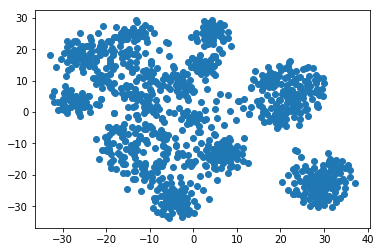

In [24]:
from sklearn.manifold import TSNE

X = model.docvecs

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1])

plt.show()